In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from scipy import stats

%matplotlib inline

/Users/bgentry/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
return false; 
}

<IPython.core.display.Javascript object>

# Pulling all data & formatting it for regression modeling
* Combine all data, delete duplicate fields
* Drop duplicate players (can't tell which college QB associated with with NFL QB)
* Move Y to first column for ease
* Create dummy variables for categorical data


In [12]:
with open("../cfb_grad_stats_2yr.pkl", 'rb') as picklefile: 
    df_cfb = pickle.load(picklefile)
with open("../player_bio.pkl", 'rb') as picklefile: 
    df_bio = pickle.load(picklefile)
with open("../nfl_year1.pkl", 'rb') as picklefile: 
    df_nfl = pickle.load(picklefile)

In [13]:
df_nfl.head()
df_nfl = df_nfl.iloc[:,7:11].copy()
del df_nfl['year']

In [14]:
# merge the data
df = df_cfb.merge(df_bio, left_on='player', right_on='name')
df = df.merge(df_nfl, on = 'player')

del df['name']
del df['year_id']

In [15]:
players_to_drop = ['Mark Miller', 'Steve Matthews', 'Ken Karcher', 'Kevin Thompson', 'Joe Reed', 'Alex Espinoza']
df = df[~df.player.isin(players_to_drop)]

In [16]:
del df['player']
df['weight'] = df.apply(lambda x: int(x['weight']), axis=1)

In [17]:
pd.set_option('display.max_columns', 500)

In [18]:
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

In [19]:
#make dummies
cat_fields = ['school_name','conf_abbr','throws','home_state','home_city']
df = pd.get_dummies(df, columns = cat_fields, drop_first=True)


In [20]:
with open('cleaned_merged.pkl', 'wb') as picklefile:
    pickle.dump(df, picklefile)

### Functions to help with analysis/transformations
* Plotting histograms of all continous variables
* Finding columns w/ continous data
* Peforming Box-Cox transformation and returning lambda & scaler
* Performing Box-Cox transformation given lambda & scaler (for test data)
* Box Cox transformation on series (used for Y values)

In [21]:
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize = (15,100))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins = 10, ax=ax)
        ax.set_title(var_name+" Distribution")
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

#draw_histograms(df, df.iloc[:,:39].columns, 20,2)

In [22]:
def get_cont_cols(df):
    cont_cols = []
    for col in df.columns:
        if df[col].dtype != 'uint8':
            cont_cols.append(col)
    return cont_cols

In [23]:
def bc_transform(df, column):
    from sklearn.preprocessing import MinMaxScaler
    from scipy import stats
    
    scalerX = MinMaxScaler((0,1)).fit(df[column])
    X_scale = scalerX.transform(df[column])
    lmbda = stats.boxcox_normmax(X_scale+.001, (-10,10))
    df[column + '_bc'] = [((x+.001)**lmbda - 1) / lmbda for x in X_scale]
    
    return lmbda, scalerX

In [24]:
def bc_transform_test(df, column, lmbda, scalerX):
    X_scale = scalerX.transform(df[column])
    df[column + '_bc'] = [((x+.001)**lmbda - 1) / lmbda for x in X_scale]


In [25]:
def bc_transform_s(srs):
    from sklearn.preprocessing import MinMaxScaler
    from scipy import stats
    
    scalerX = MinMaxScaler((1,2)).fit(srs)
    X_scale = scalerX.transform(srs)
    lmbda = stats.boxcox_normmax(X_scale+.001, (-10,10))
    srs = [((x+.001)**lmbda - 1) / lmbda for x in X_scale]
    return srs

### Attempt basic linear model - no transformations
* Initial R^2 is good, but when Train/Test/Split introduced, it's bad (overfit!)
* Attempted to use ElasticNet Regularization to improve R^2, still very poor

In [26]:
X = df.iloc[:, 1:].copy()
y = df.iloc[:, 0].copy()

    
lr = LinearRegression(fit_intercept=False)

lr.fit(X, y)
lr.score(X, y)

0.96379731322307804

In [27]:
lr = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3)
lr.fit(X_train, y_train)
lr.score(X_test,y_test)

-4.9690268715699739

In [45]:
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler

X = df.iloc[:, 1:].copy()
y = df.iloc[:, 0].copy().ravel()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3)
scalerX = StandardScaler().fit(X_train)
scalery = StandardScaler().fit(y_train)
X_train = scalerX.transform(X_train)
y_train = scalery.transform(y_train)
X_test = scalerX.transform(X_test)
y_test = scalery.transform(y_test)

rcv = ElasticNetCV(cv=10)
rcv.fit(X_train, y_train)
rcv.score(X_test, y_test)

0.0032077155104358601

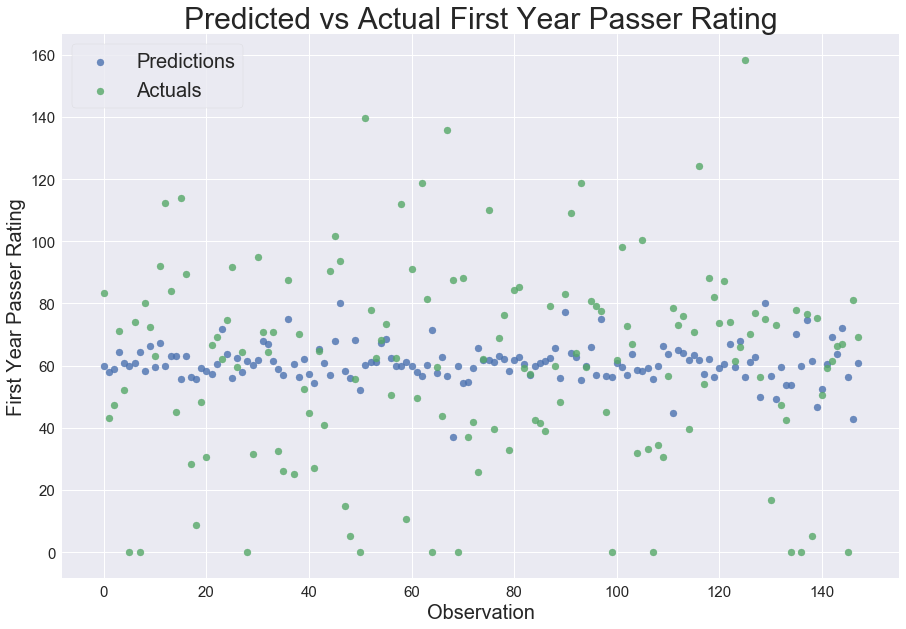

In [48]:
from sklearn.metrics import mean_squared_error
from math import sqrt

preds = (scalery.inverse_transform(rcv.predict(X_test))).tolist()
actuals = (scalery.inverse_transform(y_test))
resid = actuals - preds
r, a_sort = zip(*sorted(zip(resid, preds)))
r, b_sort = zip(*sorted(zip(resid, actuals)))


index = [i for i in range(len(preds))]
#rms = sqrt(mean_squared_error(actuals, preds))

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(111)

ax1.scatter(index, preds , label='Predictions', alpha=0.8)
ax1.scatter(index, actuals, label='Actuals', alpha=0.8)
#ax1.scatter(index, preds + rms, alpha = 0.2, color = 'r', label = 'RMSE')
#ax1.scatter(index, preds - rms, alpha = 0.2, color = 'r')
plt.title('Predicted vs Actual First Year Passer Rating', fontsize = 30)
plt.ylabel('First Year Passer Rating', fontsize = 20)
plt.xlabel('Observation', fontsize = 20)
plt.tick_params(labelsize=15)
plt.legend(frameon = 'True', fontsize = 20);

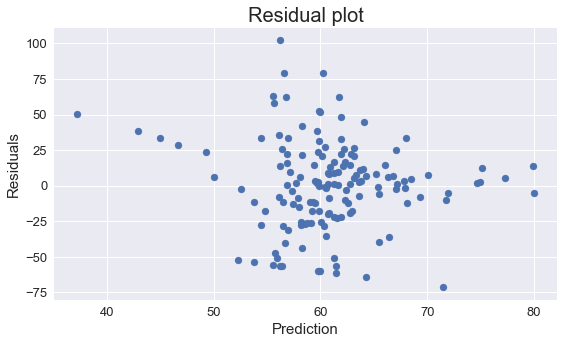

In [49]:
    plt.figure(figsize=(9,5))
    plt.scatter(preds, resid)
    plt.tick_params(labelsize=13)
    plt.title("Residual plot", size=20)
    plt.xlabel("Prediction", size=15)
    plt.ylabel("Residuals", size=15)


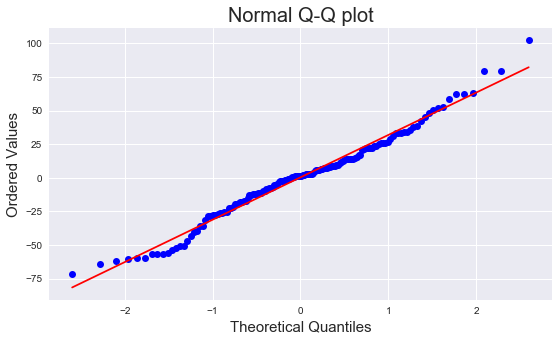

In [50]:
    plt.figure(figsize=(9,5))
    stats.probplot(resid, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot", size=20)
    plt.xlabel('Theoretical Quantiles', size=15)
    plt.ylabel('Ordered Values', size=15)

### Box-Cox Transformations on Certain Columns
* Very similar results to above - R^2 on all data was good, on train/test split it dropped dramatically
* ElasticNet also did not improve R^2 on train/test split
* Attempted polynomial features - excessively slow runtime with all categorical features

In [19]:
cols_to_transform = ['pass_td', 'pass_int', 'rec_yds', 'rush_att', 'rush_yds', 'cfb_games', 
                  'rush_att_2', 'rush_yds_2', 'pass_att_2', 'pass_cmp_2', 'pass_td_2', 'pass_yds_2', 
                  'pass_att_diff', 'rec_diff', 'rec_yds_diff']

In [20]:
X_3 = df.iloc[:, 1:].copy()
for col in cols_to_transform:
    bc_transform(X_3, col)
    del X_3[col]


In [21]:
y = df.iloc[:, 0].copy()
lr = LinearRegression(fit_intercept=False)

lr.fit(X_3, y)
lr.score(X_3, y)

0.98598835252538297

In [22]:
lr = LinearRegression()
X = X_3
y = df.iloc[:, 0].copy()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3)
lr.fit(X_train, y_train)
#lr.score(X_train, y_train)
lr.score(X_test,y_test)

-5.2628681763368119

In [70]:
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler


X_3 = df.iloc[:, 1:].copy()
y = df.iloc[:, 0].copy()

X_3_train, X_3_test, y_train, y_test = train_test_split(X_3,y,test_size=.3)

for col in cols_to_transform:
    lamb, scale = bc_transform(X_3_train, col)
    del X_3_train[col]
    bc_transform_test(X_3_test, col, lamb, scale)
    del X_3_test[col]


scalerX = StandardScaler().fit(X_3_train)
scalery = StandardScaler().fit(y_train)
X_3_train = scalerX.transform(X_3_train)
y_train = scalery.transform(y_train)
X_3_test = scalerX.transform(X_3_test)
y_test = scalery.transform(y_test)


rcv = ElasticNetCV(cv=10)
rcv.fit(X_3_train, y_train)
rcv.score(X_3_test, y_test)

0.0051415462585592264

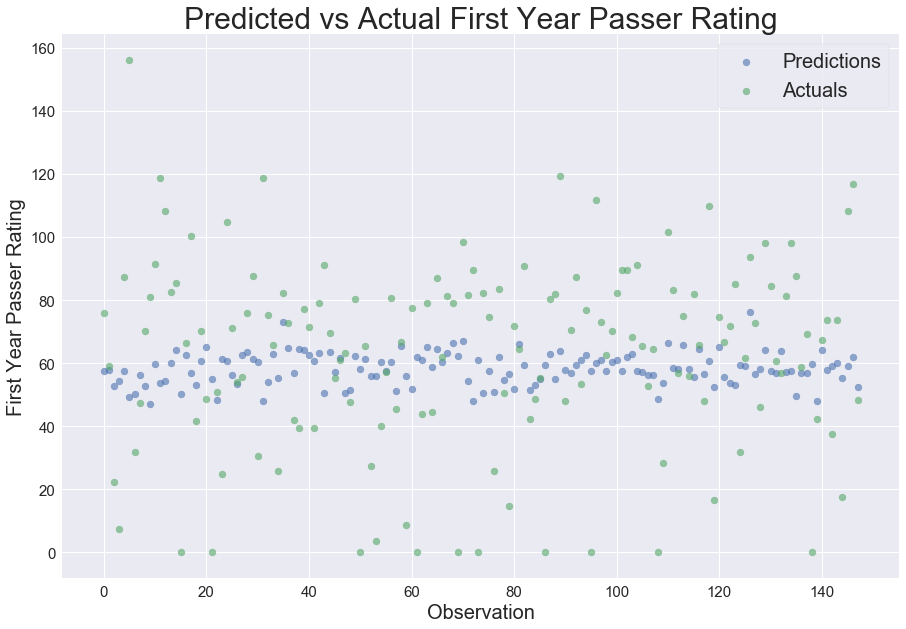

In [71]:
from sklearn.metrics import mean_squared_error
from math import sqrt

preds = (scalery.inverse_transform(rcv.predict(X_3_test))).tolist()
actuals = (scalery.inverse_transform(y_test))
resid = actuals - preds
#r, a_sort = zip(*sorted(zip(resid, preds)))
#r, b_sort = zip(*sorted(zip(resid, actuals)))


index = [i for i in range(len(preds))]
#rms = sqrt(mean_squared_error(actuals, preds))

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(111)

ax1.scatter(index, preds, label='Predictions', alpha=0.6)
ax1.scatter(index, actuals, label='Actuals', alpha=0.6)
#ax1.scatter(index, preds + rms, alpha = 0.2, color = 'r', label = 'RMSE')
#ax1.scatter(index, preds - rms, alpha = 0.2, color = 'r')
plt.title('Predicted vs Actual First Year Passer Rating', fontsize = 30)
plt.ylabel('First Year Passer Rating', fontsize = 20)
plt.xlabel('Observation', fontsize = 20)
plt.tick_params(labelsize=15)
plt.legend(frameon = 'True', fontsize = 20);

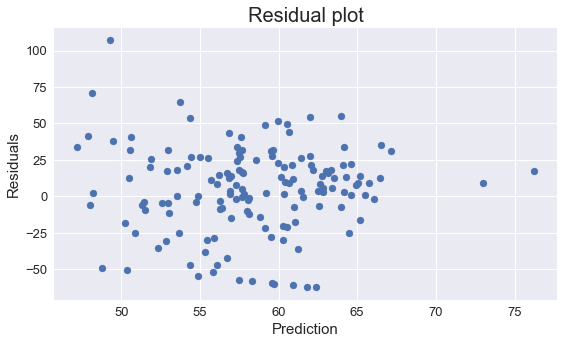

In [72]:
    plt.figure(figsize=(9,5))
    plt.scatter(preds, resid)
    plt.tick_params(labelsize=13)
    plt.title("Residual plot", size=20)
    plt.xlabel("Prediction", size=15)
    plt.ylabel("Residuals", size=15)


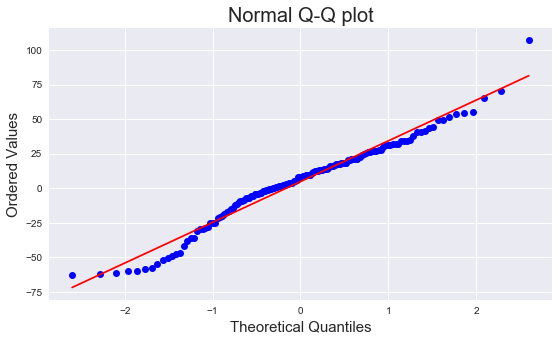

In [73]:
    plt.figure(figsize=(9,5))
    stats.probplot(resid, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot", size=20)
    plt.xlabel('Theoretical Quantiles', size=15)
    plt.ylabel('Ordered Values', size=15)

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures

X = df.iloc[:, 1:]
y = df.iloc[:, 0].ravel()
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_poly,y,test_size=.3)
scalerX = StandardScaler().fit(X_train)
scalery = StandardScaler().fit(y_train)
X_train = scalerX.transform(X_train)
y_train = scalery.transform(y_train)
X_test = scalerX.transform(X_test)
y_test = scalery.transform(y_test)


rcv = ElasticNetCV(cv=10)
rcv.fit(X_train, y_train)
rcv.score(X_test, y_test)
        